In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

csv_file = "E16.5_E1S3_cell_bin_whole_brain_noborderct.csv"

In [11]:
data = pd.read_csv(csv_file)
data

,cell_ID,x,y,sim anno
0,CELL.61,-5591.0,-1156.0,Ery
1,CELL.84,-5538.0,-1185.0,Ery
2,CELL.105,-5496.0,-1206.0,Ery
3,CELL.131,-5519.0,-1235.0,Ery
4,CELL.132,-5546.0,-1235.0,Ery
...,...,...,...,...
59699,CELL.70553,-1463.0,-8763.0,DorsHb RGC
59700,CELL.70555,-1175.0,-8770.0,Mixed GlioB
59701,CELL.70556,-1365.0,-8764.0,Mixed GlioB
59702,CELL.70557,-1425.0,-8776.0,DorsHb RGC


In [20]:
X = -8000
new_filename = "E16.5_E1S3_cell_bin_whole_brain_noborderct_filtered.csv"
data_filtered = data[data['x'] < X]

# Save the filtered DataFrame to a CSV file
data_filtered.to_csv(new_filename, index=False)

In [21]:
data_filtered

,cell_ID,x,y,sim anno
21,CELL.523,-8598.0,-1609.0,Ery
38,CELL.662,-8135.0,-1686.0,Ery
153,CELL.918,-8628.0,-1775.0,Ery
164,CELL.933,-8745.0,-1779.0,Ery
170,CELL.942,-8786.0,-1779.0,Ery
...,...,...,...,...
57869,CELL.68191,-9542.0,-8167.0,Ery
57907,CELL.68234,-9631.0,-8172.0,Hb Glu NeuB
57931,CELL.68264,-9610.0,-8173.0,Mb RGC
57935,CELL.68268,-9493.0,-8171.0,Ery


In [12]:
cells, types = get_cells_and_types(data)

====== Get cells and types from data . . .
Progress : 0/59704
Progress : 10000/59704
Progress : 20000/59704
Progress : 30000/59704
Progress : 40000/59704
Progress : 50000/59704
###### job completed in: 0:00:01.425973


In [13]:
types

{'Ery': 0,
 'Hb Glu NeuB': 1,
 'Mixed Neu': 2,
 'CR': 3,
 'Mixed GABA Neu': 4,
 'Hb Glu Neu': 5,
 'Mb Glu Neu': 6,
 'Mb Glu NeuB': 7,
 'Fb NeuB': 8,
 'Die GNeu': 9,
 'Olfa Neu': 10,
 'Unknown': 11,
 'Hypo Neu': 12,
 'VH GABA Neu': 13,
 'CortiHippo Glu Neu': 14,
 'DorsHb RGC': 15,
 'Cere Gran NeuB': 16,
 'Hb NeuB': 17,
 'Fb GABA NeuB': 18,
 'Fb Glu NeuB': 19,
 'Fb RGC': 20,
 'Mb RGC': 21,
 'Mixed GlioB': 22,
 'Fb GABA Neu': 23,
 'DA Neu': 24,
 'Hb GlioB': 25,
 'Corti Glu Neu': 26,
 'Corti prog': 27,
 'Motor Neu': 28,
 'ChP': 29}

In [15]:
cellID = np.array(data['cell_ID'])
unique_cells = np.unique(cellID)
len(unique_cells)

59704

In [17]:
data.isna().any().any() 

False

In [5]:
import scipy

class Cell:
    
    def __init__(self, cell_id, cell_num, cell_type, cell_type_num, x, y):
        self.id = cell_id
        self.id_num = cell_num
        self.cell_type = cell_type
        self.cell_type_num = cell_type_num
        self.type_percentage = None
        self.x = x
        self.y = y
    
    def set_type_percentage(self, cells, types, distance_matrix, neighborhood_diameter):
        """
        Calculate the percentage of cell types in neighborhood of 
        this cell and set it as a type_percentage parameter.
        """
        self.type_percentage = np.zeros(len(types))
        self.type_percentage[self.cell_type_num] += 1
        
        num_of_cells_in_neighborhood = 1
        for cell in cells:
            if distance_matrix[self.id_num][cell.id_num] < neighborhood_diameter:
                self.type_percentage[cell.cell_type_num] += 1
                num_of_cells_in_neighborhood += 1
                
        self.type_percentage /= num_of_cells_in_neighborhood

    def coordinate_distance_to(self, other_cell):
        """
        Calculate the Euclidean distance between this cell and another cell.
        """
        return scipy.spatial.distance.euclidean([self.x, self.y], [other_cell.x, other_cell.y])
    
    def percentage_distance_to(self, other_cell, dist="Manhattan", param=None):
        """
        Calculate the similarity (distance) between percentage 
        of types of this cell and another cell.
        """
        if dist == "Manhattan":
            return scipy.spatial.distance.cityblock(self.type_percentage, other_cell.type_percentage)
        elif dist == "Jaccard":
            p_this_cell = [1 if p > param else 0 for p in self.type_percentage]
            p_other_cell = [1 if p > param else 0 for p in other_cell.type_percentage]
            return scipy.spatial.distance.jaccard(p_this_cell, p_other_cell)
    

In [4]:
import os
from igraph import Graph
import leidenalg
from matplotlib import cm
from datetime import datetime

CONST = 10000

def get_distance_matrix(cells, distance_matrix_name, type="coordinate", neighborhood_diameter=None, dist="Manhattan", param=None):
    matrix_name = f"{type}_{distance_matrix_name}_diameter_{neighborhood_diameter}"
    if os.path.exists(f"matrices/{matrix_name}.npy"):
        print(f"====== Distance matrix {matrix_name} already exists. Fetching it.")
        return np.load(f"matrices/{matrix_name}.npy")
    else:
        start_time = datetime.now()
        print(f"====== Creating {type} distance matrix {type}_{distance_matrix_name} . . .")
        
        n = len(cells)
        distance_matrix =  np.zeros((n, n), dtype=float) 
        
        if type == "coordinate":
            for i in range(0, n - 1):
                if i % CONST == 0:
                        print(f"Progress for creating distance matrix: {i}/{n}")
                for j in range(i + 1, n):
                    distance_matrix[i][j] = cells[i].coordinate_distance_to(cells[j])
                    distance_matrix[j][i] = distance_matrix[i][j]
        else:
            for i in range(0, n - 1):
                if i % CONST == 0:
                    print(f"Progress for creating distance matrix: {i}/{n}")
                for j in range(i + 1, n):
                    distance_matrix[i][j] = cells[i].percentage_distance_to(cells[j], dist, param)
                    distance_matrix[j][i] = distance_matrix[i][j]

        print(f"Distance {type} matrix created. Saving it . . .")
        if not os.path.exists('matrices'):
            os.makedirs('matrices')
        np.save(f"matrices/{matrix_name}.npy", distance_matrix)
        
        print(f"###### job completed in: {datetime.now() - start_time}")
        return distance_matrix

def create_reduced_graph(graph_name, distance_matrix, num_of_closest_neighbors):
    if os.path.exists(f"graphs/{graph_name}"):
        print(f"Graph {graph_name} exits. Fetching it . . .")
        return Graph.Read_GraphML(f"graphs/{graph_name}")
    else:
        start_time = datetime.now()
        print(f"====== Creating graph {graph_name}. . .")
        
        reduced_graph = Graph()

        num_vertices = len(distance_matrix)
        reduced_graph.add_vertices(num_vertices)

        # Iterate through each node and identify num_of_closest_neighbors closest neighbors
        for i in range(num_vertices):
            if i % CONST ==0:
                print(f"Progress: {i}/{num_vertices}")
            # Sort neighbors by edge weight (excluding self)
            neighbors = [(j, weight) for j, weight in enumerate(distance_matrix[i]) if i != j]
            neighbors.sort(key=lambda x: x[1])

            # Add up to N closest neighbors to the reduced graph
            for j, weight in neighbors[:num_of_closest_neighbors]:
                reduced_graph.add_edge(i, j, weight=weight)
        
        # graph = Graph.Weighted_Adjacency(distance_matrix, mode='undirected', attr='weight', loops=False)
        
        print(f"Saving graph {graph_name} . . .")
        if not os.path.exists('graphs'):
            os.makedirs('graphs')
        reduced_graph.write_graphml(f"graphs/{graph_name}")
        
        print(f"###### job completed in: {datetime.now() - start_time}")
        return reduced_graph

def plot_clusters(cells, node_colors, name):
    start_time = datetime.now()
    print(f"====== Plotting clusters . . .")
    
    figure, ax = plt.subplots()
    n = len(node_colors)
    
    for cell in cells:
        if cell.id_num % CONST == 0:
            print(f"Progress for plotting clusters: {cell.id_num}/{n}")
        x = cell.x
        y = cell.y
        color = node_colors[cell.id_num]
        ax.scatter(x, y, color=color, s=5, alpha=0.7)

    ax.set_xlabel("cell x coordinate")
    ax.set_ylabel("cell y coordinate")
    ax.legend(loc='upper right')
    
    if "midbrain" not in name:
        ax.invert_yaxis()
        
    print(f"Saving plot for {name} . . .")
    figure.savefig(f"clusters__for_{name}.png")
    plt.close()
    print(f"###### job completed in: {datetime.now() - start_time}")

def cluster_leiden(graph, cells, name):
    start_time = datetime.now()
    print(f"====== Started Leiden clustering . . .")
    
    partition = leidenalg.find_partition(graph=graph, partition_type=leidenalg.ModularityVertexPartition, n_iterations=-1, seed=0)
    
    print(f"Modularity: {partition.modularity:.3f}")
    print(f"Number of clusters: {len(set(partition.membership))}")

    color_map = cm.get_cmap('tab20c', len(set(partition.membership)))
    colors = [color_map(i) for i in range(len(set(partition.membership)))]
    
    node_colors = [colors[cluster] for cluster in partition.membership]
    plot_clusters(cells, node_colors, name)
    
    print(f"###### job completed in: {datetime.now() - start_time}")
    return partition

def get_cells_and_types(data):
    start_time = datetime.now()
    print(f"====== Get cells and types from data . . .")
    
    types = {}
    cells = []
    i = 0
    n = len(data)
    for index, row in data.iterrows():
        if index % CONST == 0:
            print(f"Progress : {index}/{n}")
        if row['sim anno'] not in types:
            types[row['sim anno']] = i
            i += 1
        cell = Cell(row['cell_ID'], index, row['sim anno'], types[row['sim anno']], row['x'], row['y'])
        cells.append(cell)
        
    print(f"###### job completed in: {datetime.now() - start_time}")
    return cells, types

def set_type_percentage_for_all_cells(cells, types, filename, neighborhood_diameter):
    start_time = datetime.now()
    print(f"====== Set type_percentage for all cells . . .")
    
    distance_matrix = get_distance_matrix(cells, filename)
    n = len(cells)
    for cell in cells:
        if cell.id_num % CONST == 0:
            print(f"Progress : {cell.id_num}/{n}")
        cell.set_type_percentage(cells, types, distance_matrix, neighborhood_diameter)

    print(f"###### job completed in: {datetime.now() - start_time}")

def clustering(data, filename, neighborhood_diameter, num_of_closest_neighbors, dist="Manhattan", param=None):
    start_time = datetime.now()
    print(f"=== Clustering . . .")
    
    cells, types = get_cells_and_types(data)
    set_type_percentage_for_all_cells(cells, types, filename, neighborhood_diameter)

    percentage_distance_matrix = get_distance_matrix(cells, filename, "percentage", neighborhood_diameter, dist, param)
    graph_name = f"{filename}_diameter_{neighborhood_diameter}"
    graph = create_reduced_graph(graph_name, percentage_distance_matrix, num_of_closest_neighbors)
    
    cluster_leiden(graph, cells)
    print(f"### job completed in: {datetime.now() - start_time}")

    

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filename = "E16.5_E1S3_cell_bin_whole_brain_noborderct"
data = pd.read_csv(f"{filename}.csv")
data

,cell_ID,x,y,sim anno
0,CELL.61,-5591.0,-1156.0,Ery
1,CELL.84,-5538.0,-1185.0,Ery
2,CELL.105,-5496.0,-1206.0,Ery
3,CELL.131,-5519.0,-1235.0,Ery
4,CELL.132,-5546.0,-1235.0,Ery
...,...,...,...,...
59699,CELL.70553,-1463.0,-8763.0,DorsHb RGC
59700,CELL.70555,-1175.0,-8770.0,Mixed GlioB
59701,CELL.70556,-1365.0,-8764.0,Mixed GlioB
59702,CELL.70557,-1425.0,-8776.0,DorsHb RGC


In [7]:
cells, types = get_cells_and_types(data)
percentage_distance_matrix = percentage_distance_matrix = get_distance_matrix(cells, filename, "percentage", 500, dist="Manhattan", param=None)

====== Get cells and types from data . . .
Progress : 0/59704
Progress : 10000/59704
Progress : 20000/59704
Progress : 30000/59704
Progress : 40000/59704
Progress : 50000/59704
###### job completed in: 0:00:01.367247
====== Distance matrix percentage_E16.5_E1S3_cell_bin_whole_brain_noborderct_diameter_500 already exists. Fetching it.


In [10]:
graph_name = f"{filename}_diameter_500"
graph = create_reduced_graph(graph_name, percentage_distance_matrix, 20)

====== Creating graph E16.5_E1S3_cell_bin_whole_brain_noborderct_diameter_500. . .
Saving graph E16.5_E1S3_cell_bin_whole_brain_noborderct_diameter_500 . . .
###### job completed in: 4:28:28.701878


In [12]:
cluster_leiden(graph, cells, graph_name)

====== Started Leiden clustering . . .
Modularity: 0.952
Number of clusters: 52
====== Plotting clusters . . .
Progress for plotting clusters: 0/59704


/var/folders/rn/32tjnw7n5291gqj65jm1pl4r0000gp/T/ipykernel_39299/1393352046.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20c', len(set(partition.membership)))


Progress for plotting clusters: 10000/59704
Progress for plotting clusters: 20000/59704
Progress for plotting clusters: 30000/59704
Progress for plotting clusters: 40000/59704
Progress for plotting clusters: 50000/59704
Saving plot for E16.5_E1S3_cell_bin_whole_brain_noborderct_diameter_500 . . .
###### job completed in: 0:49:32.495473
###### job completed in: 0:49:39.366477


In [13]:
def plot_values(data, bins=100, color="#0000FF"):
    plt.hist(data, bins)

    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.show()

In [15]:
matrix_name = "percentage_Mouse_embryo_E95_E1S1_diameter_5"
if os.path.exists(f"matrices/{matrix_name}.npy"):
    print(f"====== Distance matrix {matrix_name} already exists. Fetching it.")
    matrix = np.load(f"matrices/{matrix_name}.npy")

====== Distance matrix percentage_Mouse_embryo_E95_E1S1_diameter_5 already exists. Fetching it.


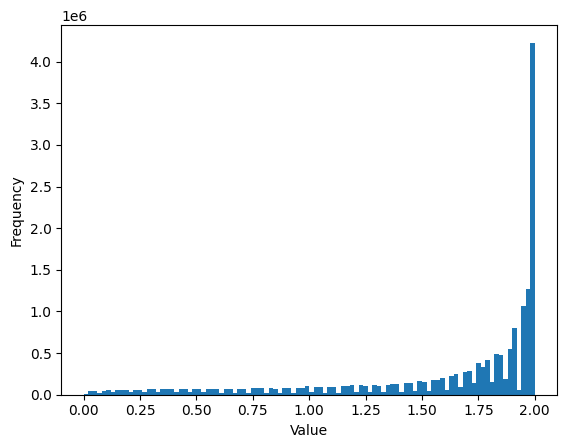

In [17]:
plot_values(upper_triangle_array)

In [ ]:
def map_values(types, value):
    return types[value]

,cell_ID,x,y,sim anno
0,CELL.61,-5591.0,-1156.0,0
1,CELL.84,-5538.0,-1185.0,0
2,CELL.105,-5496.0,-1206.0,0
3,CELL.131,-5519.0,-1235.0,0
4,CELL.132,-5546.0,-1235.0,0
...,...,...,...,...
59699,CELL.70553,-1463.0,-8763.0,15
59700,CELL.70555,-1175.0,-8770.0,22
59701,CELL.70556,-1365.0,-8764.0,22
59702,CELL.70557,-1425.0,-8776.0,15


In [37]:
colors = [
    '#FF0000',  # Red
    '#00FF00',  # Green
    '#0000FF',  # Blue
    '#FFFF00',  # Yellow
    '#FF00FF',  # Magenta
    '#00FFFF',  # Cyan
    '#800000',  # Maroon
    '#008000',  # Olive
    '#000080',  # Navy
    '#808000',  # Olive
    '#800080',  # Purple
    '#008080',  # Teal
    '#808080',  # Gray
    '#C0C0C0',  # Silver
    '#808000',  # Olive
    '#800080',  # Purple
    '#008080',  # Teal
    '#FF8000',  # Orange
    '#FF0080',  # Fuchsia
    '#80FF00',  # Lime
    '#0080FF',  # Sky Blue
    '#8000FF',  # Indigo
    '#80FFFF',  # Light Blue
    '#FF80FF',  # Pink
    '#FFFF80',  # Light Yellow
    '#004080',  # Dark Blue
    '#408000',  # Dark Green
    '#804000',  # Brown
    '#800040',  # Dark Pink
    '#004080',  # Dark Teal
    '#400080'   # Dark Purple
]

In [52]:
def plot_cells(cell_coord):
    figure, ax = plt.subplots()

    for i in len(cell_coord):
        [x, y] = cell_coord[i]
        color = colors[cell_types[i]]
        ax.scatter(x, y, color=color, s=5, alpha=0.7)

    ax.set_xlabel("cell x coordinate")
    ax.set_ylabel("cell y coordinate")

    plt.show()

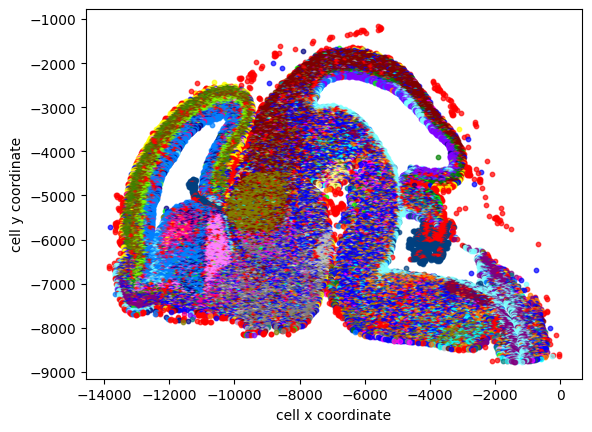

In [51]:
plot_cells([cell.x, cell.y] for cell in cells)

In [ ]:
import scipy
    

def percentage_of_types(cell_i, cells, cell_types_num, neighborhood_diameter):
    p = np.zeros(cell_types_num)
    p[types[cell_i]] += 1
    cell_num = 1
    distance_matrix = get_distance_matrix(cells)
    n = len(distance_matrix[cell_i])
    for cell_j in range(0, n):
        if distance_matrix[cell_i][cell_j] < neighborhood_diameter:
            p[types[cell_j]] += 1
            cell_num += 1
    return p/cell_num
    
    
def calculate_distance(cell_i, cell_j, cell_types_num, dist, cell_neighborhood, neighborhood_param, param):
    p_i = percentage_of_types(cell_i, cell_types_num, cell_neighborhood, neighborhood_param)
    p_j = percentage_of_types(cell_j, cell_types_num, cell_neighborhood, neighborhood_param)
    if dist == "Manhattan":
        return scipy.spatial.distance.cityblock(p_i, p_j)
    elif dist == "Jaccard":
        p_i = [1 if p > param else 0 for p in p_i]
        p_j = [1 if p > param else 0 for p in p_j]
        return scipy.spatial.distance.jaccard(p_i, p_j)

In [69]:
def plot_values(data, bins=100, color="#0000FF"):
    plt.hist(data, bins)

    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.show()

In [63]:
import scipy.spatial.distance as distance_
n = len(coordinates)
distance_matrix =  np.zeros((n, n), dtype=float)  # For floating-point values
distances = []

for i in range(0, n - 1):
    for j in range(i + 1, n):
        if i == 10000 and j == n - 1:
            print(f"Progress {i}/{n}")
        distance_matrix[i][j] = distance_.euclidean(coordinates[i], coordinates[j])
        distance_matrix[j][i] = distance_matrix[i][j]

distance_matrix = np.array(distance_matrix)

Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 10000/59704
Progress 1000

In [71]:
distances = distance_matrix[np.triu_indices(distance_matrix.shape[0], k=1)]

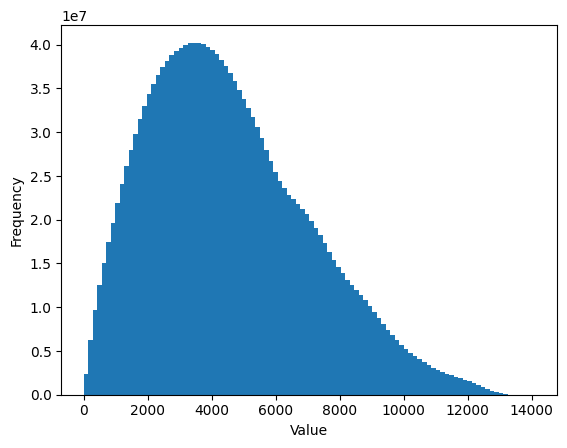

In [70]:
plot_values(distances)

In [75]:
def plot_num_of_closest(dist):
    closest_neighbors = np.zeros(n)
    for i in range(0,n):
        for j in range(0, n):
            if i == j:
                continue
            if distance_matrix[i][j] < dist:
                closest_neighbors[i] += 1

    print(f"MIN = {np.min(closest_neighbors)}")
    print(f"MAX = {np.max(closest_neighbors)}")
    
    plot_values(closest_neighbors)

MIN = 0.0
MAX = 1247.0


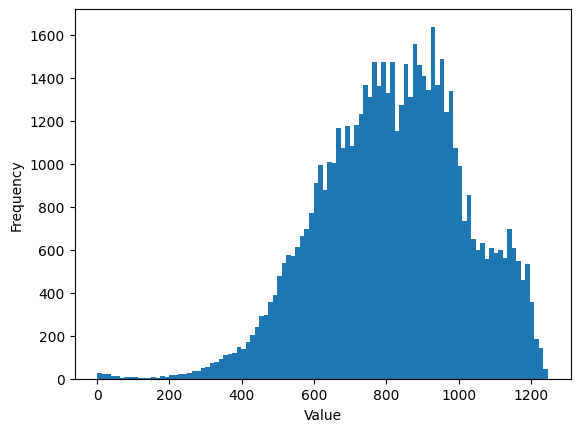

In [76]:
plot_num_of_closest(500)